In [1]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
 

In [2]:
modeledWorld1 = ModeledPopulatedWorld(100,400,5)

In [3]:
simulation1 = Simulation(modeledWorld1,100)


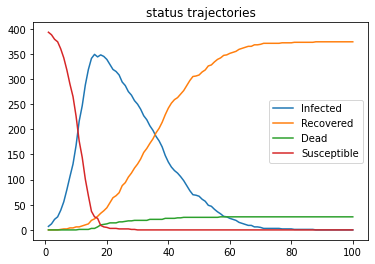

In [4]:
simulation1.plot_status_timecourse()


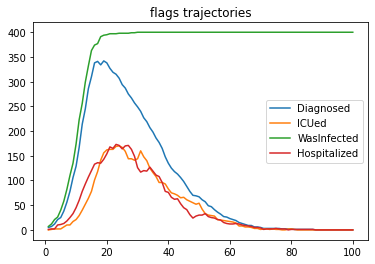

In [5]:
simulation1.plot_flags_timecourse()


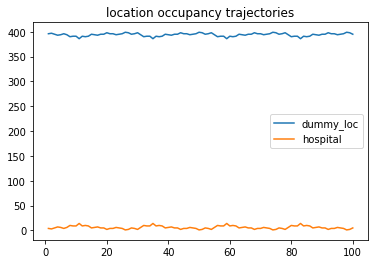

In [6]:
simulation1.plot_location_type_occupancy_timecourse()